In [2]:
import gymnasium as gym
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy
import torch
import numpy as np
import matplotlib.pyplot as plt
from minigrid.wrappers import ImgObsWrapper
from IPython.display import display

from sb3_ppo import make_ppo_agent
from evaluation.evaluation import capture_frames_sb3, count_parameters
from evaluation.visualization import create_animation
from wrappers import BaseWrapper, RandomRotateWrapper, Rotate90Wrapper, Rotate180Wrapper, Rotate270Wrapper

In [3]:
# Configuration
ENV_NAME = 'MiniGrid-FourRooms-v0'

# Training parameters
TIMESTEPS = 1e6

# Evaluation parameters
NUM_EVAL_EPISODES = 10
RENDER_EVALUATION = True

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## 1. Setting Up the Environment

We'll use the MiniGrid environment wrapped with ImgObsWrapper to provide image observations.

In [7]:
num_envs = 16
std_vec_env = make_vec_env(ENV_NAME, n_envs=num_envs, seed=SEED,
                               wrapper_class=BaseWrapper,
                               monitor_dir='./logs/std')
aug_vec_env = make_vec_env(ENV_NAME, n_envs=num_envs, seed=SEED,
                               wrapper_class=RandomRotateWrapper,
                               wrapper_kwargs={'subset': [0,1]},
                               monitor_dir='./logs/aug')
eq_vec_env = make_vec_env(ENV_NAME, n_envs=num_envs, seed=SEED,
                               wrapper_class=BaseWrapper,
                               monitor_dir='./logs/eq')
aug_eq_vec_env = make_vec_env(ENV_NAME, n_envs=num_envs, seed=SEED,
                               wrapper_class=RandomRotateWrapper,
                               wrapper_kwargs={'subset': [0,1]},
                               monitor_dir='./logs/aug_eq')

In [8]:
def make_eval_env(wrapper_class=None, subset=None):
    env = gym.make(ENV_NAME, render_mode="rgb_array")
    if wrapper_class is None:
        env = BaseWrapper(env)
    else:
        if subset is None:
            env = wrapper_class(env)
        else:
            env = wrapper_class(env, subset)
    env = Monitor(env)
    return env

In [9]:
eval_env = make_eval_env()
eval_90_env = make_eval_env(Rotate90Wrapper)
eval_180_env = make_eval_env(Rotate180Wrapper)
eval_270_env = make_eval_env(Rotate270Wrapper)
eval_rand_env = make_eval_env(RandomRotateWrapper, subset=[0, 1, 2, 3])
eval_0_90_env = make_eval_env(RandomRotateWrapper, subset=[0, 1])
eval_180_270_env = make_eval_env(RandomRotateWrapper, subset=[2, 3])

print(f"Environment: {ENV_NAME}")
print(f"Observation shape: {eval_env.observation_space.shape}")
print(f"Action space: {eval_env.action_space}")

Environment: MiniGrid-FourRooms-v0
Observation shape: (7, 7, 3)
Action space: Discrete(7)


## 2. PPO Default Hyperparameters

Below are the default hyperparameters for PPO that can be configured:

In [11]:
default_ppo_params = {
    "learning_rate": 2.5e-4,
    "n_steps": 1024,
    "batch_size": 256,
    "n_epochs": 4,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "clip_range_vf": None,
    "normalize_advantage": True,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
}

standard_config = default_ppo_params.copy()
equivariant_config = default_ppo_params.copy()

## 3. Training Agents

Train both the standard CNN and C4 equivariant CNN PPO agents.

In [12]:
# Train standard CNN PPO agent
standard_agent = make_ppo_agent(
    std_vec_env, 
    use_equivariant_cnn=False, 
    seed=SEED,
    config=standard_config
)
print(f"Training standard CNN PPO for {TIMESTEPS} timesteps...")
standard_agent.learn(total_timesteps=int(TIMESTEPS))
print("Standard CNN training completed!")

Using cpu device
Wrapping the env in a VecTransposeImage.
Training standard CNN PPO for 1000000.0 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.5     |
|    ep_rew_mean     | 0.0479   |
| time/              |          |
|    fps             | 2008     |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 16384    |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 97.5       |
|    ep_rew_mean          | 0.0272     |
| time/                   |            |
|    fps                  | 1452       |
|    iterations           | 2          |
|    time_elapsed         | 22         |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.00987791 |
|    clip_fraction        | 0.0414     |
|    clip_range           | 0.2        |
|    entropy_los

KeyboardInterrupt: 

In [ ]:
# Train equivariant CNN PPO agent
equivariant_agent = make_ppo_agent(
    eq_vec_env, 
    use_equivariant_cnn=True, 
    seed=SEED,
    config=equivariant_config
)
print(f"Training equivariant CNN PPO for {TIMESTEPS} timesteps...")
equivariant_agent.learn(total_timesteps=int(TIMESTEPS))
print("Equivariant CNN training completed!")

Using cpu device
Wrapping the env in a VecTransposeImage.
Training equivariant CNN PPO for 50000.0 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 87.8     |
|    ep_rew_mean     | 0.141    |
| time/              |          |
|    fps             | 1575     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 81.8        |
|    ep_rew_mean          | 0.206       |
| time/                   |             |
|    fps                  | 378         |
|    iterations           | 2           |
|    time_elapsed         | 21          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.014909187 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
| 

In [24]:
# Train augmented standard CNN PPO agent
aug_agent = make_ppo_agent(
    aug_vec_env, 
    use_equivariant_cnn=False, 
    seed=SEED,
    config=standard_config
)
print(f"Training augmented standard CNN PPO for {TIMESTEPS} timesteps...")
aug_agent.learn(total_timesteps=int(TIMESTEPS))
print("Augmented standard CNN training completed!")

Using cpu device
Wrapping the env in a VecTransposeImage.
Training augmented standard CNN PPO for 50000.0 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 77.7     |
|    ep_rew_mean     | 0.249    |
| time/              |          |
|    fps             | 2046     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 78.3        |
|    ep_rew_mean          | 0.241       |
| time/                   |             |
|    fps                  | 1198        |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.013895087 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2      

In [25]:
# Train augmented equivariant CNN PPO agent
aug_equivariant_agent = make_ppo_agent(
    aug_eq_vec_env, 
    use_equivariant_cnn=True, 
    seed=SEED,
    config=equivariant_config
)
print(f"Training augmented equivariant CNN PPO for {TIMESTEPS} timesteps...")
aug_equivariant_agent.learn(total_timesteps=int(TIMESTEPS))
print("Augmented equivariant CNN training completed!")

Using cpu device
Wrapping the env in a VecTransposeImage.
Training augmented equivariant CNN PPO for 50000.0 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 87.8     |
|    ep_rew_mean     | 0.141    |
| time/              |          |
|    fps             | 1781     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 83.5        |
|    ep_rew_mean          | 0.188       |
| time/                   |             |
|    fps                  | 494         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.014584042 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2   

In [44]:
# print("Eval Standard Wrapper")
# # Evaluate standard CNN agent
# print("\n=== Standard CNN PPO Evaluation ===")
# std_mean_reward, std_std_reward = evaluate_policy(standard_agent, eval_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=True)
# print(f"Mean reward: {std_mean_reward:.2f} +/- {std_std_reward:.2f}")
# # Evaluate data-augmented standard CNN agent
# print("\n=== Data-Augmented Standard CNN PPO Evaluation ===")
# aug_mean_reward, aug_std_reward = evaluate_policy(aug_agent, eval_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=True)
# print(f"Mean reward: {aug_mean_reward:.2f} +/- {aug_std_reward:.2f}")
# # Evaluate equivariant CNN agent
# print("\n=== C4 Equivariant CNN PPO Evaluation ===")
# eq_mean_reward, eq_std_reward = evaluate_policy(equivariant_agent, eval_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=True)
# print(f"Mean reward: {eq_mean_reward:.2f} +/- {eq_std_reward:.2f}")
# # Evaluate data-augmented equivariant CNN agent
# print("\n=== Data-Augmented C4 Equivariant CNN PPO Evaluation ===")
# aug_eq_mean_reward, aug_eq_std_reward = evaluate_policy(aug_equivariant_agent, eval_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=True)
# print(f"Mean reward: {aug_eq_mean_reward:.2f} +/- {aug_eq_std_reward:.2f}")

# print('------'*10)
# print("Eval Random Wrapper")
# is_deterministic = False
# # Evaluate standard CNN agent
# print("\n=== Standard CNN PPO Evaluation ===")
# std_mean_reward, std_std_reward = evaluate_policy(standard_agent, eval_rand_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {std_mean_reward:.2f} +/- {std_std_reward:.2f}")

# # Evaluate data-augmented standard CNN agent
# print("\n=== Data-Augmented Standard CNN PPO Evaluation ===")
# aug_mean_reward, aug_std_reward = evaluate_policy(aug_agent, eval_rand_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_mean_reward:.2f} +/- {aug_std_reward:.2f}")

# # Evaluate equivariant CNN agent
# print("\n=== C4 Equivariant CNN PPO Evaluation ===")
# eq_mean_reward, eq_std_reward = evaluate_policy(equivariant_agent, eval_rand_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {eq_mean_reward:.2f} +/- {eq_std_reward:.2f}")

# # Evaluate data-augmented equivariant CNN agent
# print("\n=== Data-Augmented C4 Equivariant CNN PPO Evaluation ===")
# aug_eq_mean_reward, aug_eq_std_reward = evaluate_policy(aug_equivariant_agent, eval_rand_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_eq_mean_reward:.2f} +/- {aug_eq_std_reward:.2f}")

# print('------'*10)
# print("Eval 90-deg Wrapper")
# # Evaluate 90-degree rotated environment
# print("\n=== 90-degree Rotated Environment Evaluation ===")
# std_90_mean_reward, std_90_std_reward = evaluate_policy(standard_agent, eval_90_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {std_90_mean_reward:.2f} +/- {std_90_std_reward:.2f}")
# print("\n=== Data-Augmented 90-degree Rotated Environment Evaluation ===")
# aug_90_mean_reward, aug_90_std_reward = evaluate_policy(aug_agent, eval_90_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_90_mean_reward:.2f} +/- {aug_90_std_reward:.2f}")
# print("\n=== C4 Equivariant 90-degree Rotated Environment Evaluation ===")
# eq_90_mean_reward, eq_90_std_reward = evaluate_policy(equivariant_agent, eval_90_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {eq_90_mean_reward:.2f} +/- {eq_90_std_reward:.2f}")
# print("\n=== Data-Augmented C4 Equivariant 90-degree Rotated Environment Evaluation ===")
# aug_eq_90_mean_reward, aug_eq_90_std_reward = evaluate_policy(aug_equivariant_agent, eval_90_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_eq_90_mean_reward:.2f} +/- {aug_eq_90_std_reward:.2f}")

# print('------'*10)
# print("Eval 180-deg Wrapper")
# # Evaluate 180-degree rotated environment
# print("\n=== 180-degree Rotated Environment Evaluation ===")
# std_180_mean_reward, std_180_std_reward = evaluate_policy(standard_agent, eval_180_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {std_180_mean_reward:.2f} +/- {std_180_std_reward:.2f}")
# print("\n=== Data-Augmented 180-degree Rotated Environment Evaluation ===")
# aug_180_mean_reward, aug_180_std_reward = evaluate_policy(aug_agent, eval_180_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_180_mean_reward:.2f} +/- {aug_180_std_reward:.2f}")
# print("\n=== C4 Equivariant 180-degree Rotated Environment Evaluation ===")
# eq_180_mean_reward, eq_180_std_reward = evaluate_policy(equivariant_agent, eval_180_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {eq_180_mean_reward:.2f} +/- {eq_180_std_reward:.2f}")
# print("\n=== Data-Augmented C4 Equivariant 180-degree Rotated Environment Evaluation ===")
# aug_eq_180_mean_reward, aug_eq_180_std_reward = evaluate_policy(aug_equivariant_agent, eval_180_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_eq_180_mean_reward:.2f} +/- {aug_eq_180_std_reward:.2f}")

# print('------'*10)
# print("Eval 270-deg Wrapper")
# # Evaluate 270-degree rotated environment
# print("\n=== 270-degree Rotated Environment Evaluation ===")
# std_270_mean_reward, std_270_std_reward = evaluate_policy(standard_agent, eval_270_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {std_270_mean_reward:.2f} +/- {std_270_std_reward:.2f}")
# print("\n=== Data-Augmented 270-degree Rotated Environment Evaluation ===")
# aug_270_mean_reward, aug_270_std_reward = evaluate_policy(aug_agent, eval_270_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_270_mean_reward:.2f} +/- {aug_270_std_reward:.2f}")
# print("\n=== C4 Equivariant 270-degree Rotated Environment Evaluation ===")
# eq_270_mean_reward, eq_270_std_reward = evaluate_policy(equivariant_agent, eval_270_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {eq_270_mean_reward:.2f} +/- {eq_270_std_reward:.2f}")
# print("\n=== Data-Augmented C4 Equivariant 270-degree Rotated Environment Evaluation ===")
# aug_eq_270_mean_reward, aug_eq_270_std_reward = evaluate_policy(aug_equivariant_agent, eval_270_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_eq_270_mean_reward:.2f} +/- {aug_eq_270_std_reward:.2f}")

In [12]:
def eval_success(model, env, n_episodes=50):
    success = 0
    returns = []
    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False
        truncated = False
        total_reward = 0
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=False)
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
        returns.append(total_reward)
        if done and reward > 0:
            success += 1
    success_rate = success / n_episodes
    avg_return = np.mean(returns)
    return success_rate, avg_return

def run_eval_success_experiment(env):
    sr_std, ret_std = eval_success(standard_agent, env)
    sr_aug, ret_aug = eval_success(aug_agent, env)
    sr_equiv, ret_equiv = eval_success(equivariant_agent, env)
    sr_aug_eq, ret_aug_eq = eval_success(aug_equivariant_agent, env)
    print(f"Success rate (standard): {sr_std:.2f}, Average return: {ret_std:.2f}")
    print(f"Success rate (augmented): {sr_aug:.2f}, Average return: {ret_aug:.2f}")
    print(f"Success rate (equivariant): {sr_equiv:.2f}, Average return: {ret_equiv:.2f}")
    print(f"Success rate (augmented equivariant): {sr_aug_eq:.2f}, Average return: {ret_aug_eq:.2f}")

In [13]:
print('Base Environment')
run_eval_success_experiment(eval_env)
print('------'*10)

print("Random Environment")
run_eval_success_experiment(eval_rand_env)
print('------'*10)

print("90-degree Environment")
run_eval_success_experiment(eval_90_env)
print('------'*10)

print("180-degree Environment")
run_eval_success_experiment(eval_180_env)
print('------'*10)

print("270-degree Environment")
run_eval_success_experiment(eval_270_env)
print('------'*10)

print("180-270-degree Environment")
run_eval_success_experiment(eval_180_270_env)

Base Environment
Success rate (standard): 0.64, Average return: 0.38
Success rate (augmented): 0.52, Average return: 0.28
Success rate (equivariant): 0.72, Average return: 0.39
Success rate (augmented equivariant): 0.62, Average return: 0.35
------------------------------------------------------------
Random Environment
Success rate (standard): 0.54, Average return: 0.27
Success rate (augmented): 0.70, Average return: 0.43
Success rate (equivariant): 0.64, Average return: 0.42
Success rate (augmented equivariant): 0.66, Average return: 0.36
------------------------------------------------------------
90-degree Environment
Success rate (standard): 0.48, Average return: 0.28
Success rate (augmented): 0.70, Average return: 0.34
Success rate (equivariant): 0.58, Average return: 0.36
Success rate (augmented equivariant): 0.72, Average return: 0.42
------------------------------------------------------------
180-degree Environment
Success rate (standard): 0.48, Average return: 0.25
Success r

In [61]:
run_eval_success_experiment(eval_180_env)

Success rate (standard): 0.00, Average return: 0.00
Success rate (augmented): 0.42, Average return: 0.23
Success rate (equivariant): 0.00, Average return: 0.00
Success rate (augmented equivariant): 0.00, Average return: 0.00


In [ ]:
# def debug_evaluation(agent, env, n_episodes=1):
#     for ep in range(n_episodes):
#         obs, info = env.reset()
#         done = False
#         terminated = False
#         truncated = False
#         total_reward = 0
#         step = 0
        
#         while not (terminated or truncated) and step < 100:  # Generous step limit
#             action, _ = agent.predict(obs, deterministic=True)
#             next_obs, reward, terminated, truncated, info = env.step(action)
            
#             # Print detailed information
#             print(f"Step {step}: Action={action}, Reward={reward}, Done={terminated or truncated}")
            
#             total_reward += reward
#             obs = next_obs
#             step += 1
            
#             if terminated:
#                 print(f"Episode terminated at step {step} with total reward {total_reward}")
#             elif truncated:
#                 print(f"Episode truncated at step {step} with total reward {total_reward}")
        
#         print(f"Episode {ep+1} completed with total reward: {total_reward}")
    
# print("\nDebugging standard agent evaluation:")
# debug_evaluation(standard_agent, eval_env)


Debugging standard agent evaluation:
Step 0: Action=2, Reward=0, Done=False
Step 1: Action=2, Reward=0, Done=False
Step 2: Action=2, Reward=0, Done=False
Step 3: Action=2, Reward=0, Done=False
Step 4: Action=2, Reward=0, Done=False
Step 5: Action=2, Reward=0, Done=False
Step 6: Action=2, Reward=0, Done=False
Step 7: Action=2, Reward=0, Done=False
Step 8: Action=2, Reward=0, Done=False
Step 9: Action=2, Reward=0, Done=False
Step 10: Action=2, Reward=0, Done=False
Step 11: Action=2, Reward=0, Done=False
Step 12: Action=2, Reward=0, Done=False
Step 13: Action=2, Reward=0, Done=False
Step 14: Action=2, Reward=0, Done=False
Step 15: Action=2, Reward=0, Done=False
Step 16: Action=2, Reward=0, Done=False
Step 17: Action=2, Reward=0, Done=False
Step 18: Action=2, Reward=0, Done=False
Step 19: Action=2, Reward=0, Done=False
Step 20: Action=2, Reward=0, Done=False
Step 21: Action=2, Reward=0, Done=False
Step 22: Action=2, Reward=0, Done=False
Step 23: Action=2, Reward=0, Done=False
Step 24: Act

## 4. Training Curves

In [26]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folders, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    for log_folder in log_folders:
        x, y = ts2xy(load_results(log_folder), "timesteps")
        y = moving_average(y, window=50)
        x = x[len(x) - len(y) :]

        fig = plt.figure(title)
        plt.plot(x, y)
        plt.xlabel("Number of Timesteps")
        plt.ylabel("Rewards")
        plt.title(title + " Smoothed")
    plt.legend(log_folders)
    plt.show()

In [27]:
xa, ya = ts2xy(load_results('./logs/std'), "timesteps")
xa

array([   63,   163,   263, ..., 53223, 53228, 53236], shape=(2990,))

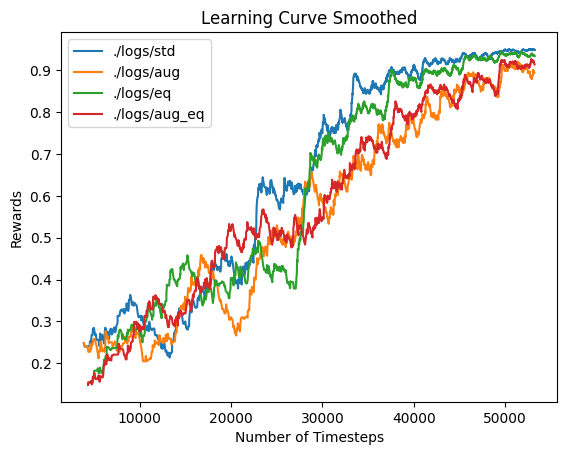

In [28]:
plot_results(['./logs/std', './logs/aug', './logs/eq', './logs/aug_eq'], title="Learning Curve")

## Visualizing Custom PPO Agent

Standard CNN PPO Agent Trajectory:


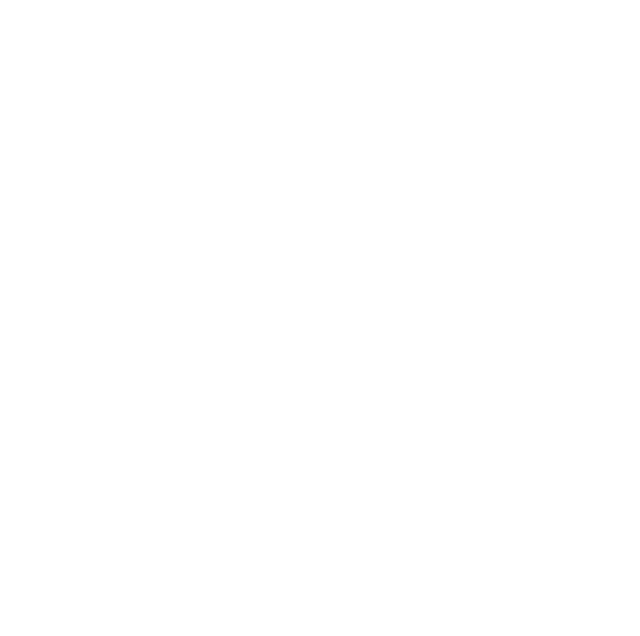

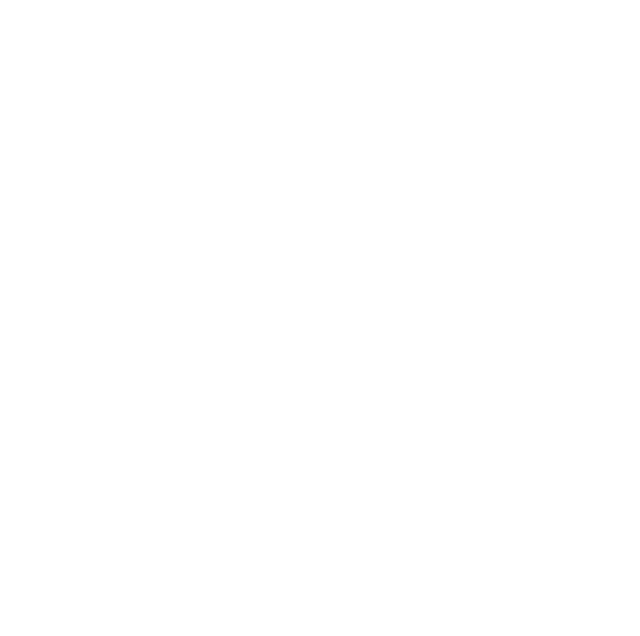

In [39]:
# Visualize standard CNN agent behavior
print("Standard CNN PPO Agent Trajectory:")
std_frames = capture_frames_sb3(equivariant_agent, eval_env)
display(create_animation(std_frames))

eq_frames = capture_frames_sb3(equivariant_agent, eval_270_env)
display(create_animation(eq_frames))

Standard CNN PPO Architecture:
ActorCriticCnnPolicy(
  (features_extractor): MinigridFeaturesExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): MinigridFeaturesExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReL

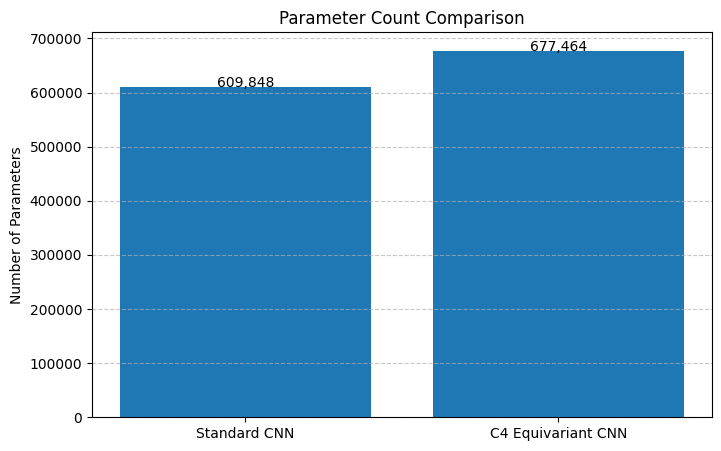

In [24]:
# Print model architectures
print("Standard CNN PPO Architecture:")
print(standard_agent.policy)
print("\nC4 Equivariant CNN PPO Architecture:")
print(equivariant_agent.policy)

# Compare parameter counts
std_params = count_parameters(standard_agent.policy)
eq_params = count_parameters(equivariant_agent.policy)

print(f"\nParameter Count Comparison:")
print(f"Standard CNN PPO: {std_params:,} parameters")
print(f"C4 Equivariant CNN PPO: {eq_params:,} parameters")

# Plot parameter comparison
labels = ['Standard CNN', 'C4 Equivariant CNN']
values = [std_params, eq_params]
plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.title('Parameter Count Comparison')
plt.ylabel('Number of Parameters')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:,}", ha='center')
plt.show()

## 5. Testing Equivariance of Agents

In [48]:
def test_equivariance(agent, env, transform_fn):
    obs, _ = env.reset()
    action_original, _ = agent.predict(obs, deterministic=True)
    transformed_obs = transform_fn(obs)
    action_transformed, _ = agent.predict(transformed_obs, deterministic=True)
    print(action_original, action_transformed)
    return action_original == action_transformed

# Example usage:
def rotate_observation_90(obs):
    return np.rot90(obs, k=1, axes=(0, 1)).copy()

is_equivariant = test_equivariance(equivariant_agent, eval_env, rotate_observation_90)
print(f"Is the agent equivariant under 90-degree rotation? {is_equivariant}")

2 1
Is the agent equivariant under 90-degree rotation? False
